# Модель VECM (пакет [`statsmodels`](https://www.statsmodels.org/stable/index.html))

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank, select_order

import pandas_datareader.data as web

# настройки визуализация
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

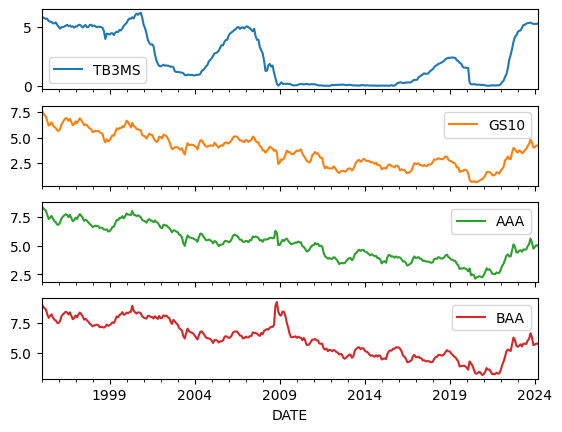

In [3]:
y = web.DataReader(name=['TB3MS', 'GS10', 'AAA', 'BAA'], data_source='fred', start='1995-01-01')

y.plot(subplots=True)
plt.show()

## Тест на коинтеграцию

In [11]:
# тест Johansen
coint_res = coint_johansen(y, det_order=0, k_ar_diff=2)

In [12]:
# trace-stat & critical
coint_res.trace_stat, coint_res.trace_stat_crit_vals

(array([58.18737247, 28.66123695, 10.85835757,  4.28172646]),
 array([[44.4929, 47.8545, 54.6815],
        [27.0669, 29.7961, 35.4628],
        [13.4294, 15.4943, 19.9349],
        [ 2.7055,  3.8415,  6.6349]]))

In [13]:
# eigenvalue-stat & critical
coint_res.max_eig_stat, coint_res.max_eig_stat_crit_vals

(array([29.52613552, 17.80287939,  6.57663111,  4.28172646]),
 array([[25.1236, 27.5858, 32.7172],
        [18.8928, 21.1314, 25.865 ],
        [12.2971, 14.2639, 18.52  ],
        [ 2.7055,  3.8415,  6.6349]]))

In [8]:
# подбор ранга коинтеграции
select_coint_rank(y, det_order=0, k_ar_diff=2, method='trace', signif=0.05).summary()

r_0,r_1,test statistic,critical value
0,4,58.19,47.85
1,4,28.66,29.80


In [16]:
# выбор порядка лагов для VECM
select_order(y, maxlags=2, deterministic='c').summary()

,AIC,BIC,FPE,HQIC
0,-15.69,-15.47,1.540e-07,-15.60
1,-16.28,-15.88*,8.489e-08,-16.12*
2,-16.29*,-15.71,8.455e-08*,-16.06


## Подгонка VECM

In [17]:
mod = VECM(y, k_ar_diff=1, coint_rank=1, deterministic='co', missing='drop')

res = mod.fit()

res.summary(alpha=0.05)

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.1102,0.037,3.006,0.003,0.038,0.182
L1.TB3MS,0.3990,0.055,7.295,0.000,0.292,0.506
L1.GS10,0.0617,0.077,0.799,0.424,-0.090,0.213
L1.AAA,-0.0604,0.124,-0.487,0.626,-0.303,0.183
L1.BAA,0.0368,0.081,0.453,0.651,-0.123,0.196
,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0770,0.048,-1.620,0.105,-0.170,0.016
L1.TB3MS,0.0129,0.071,0.181,0.856,-0.126,0.152
L1.GS10,0.1935,0.100,1.933,0.053,-0.003,0.390
L1.AAA,0.2937,0.161,1.827,0.068,-0.021,0.609


## Диагностика модели

In [18]:
# тест на серийную корреляцию
res.test_whiteness(nlags=10, signif=0.05, adjusted=True).summary()

Test statistic,Critical value,p-value,df
219.7,168.6,0.000,140


## Прогнозирование

In [21]:
# преобразуем y в формат numpy
res.predict(steps=10)

array([[5.24184755, 4.20075664, 4.99867778, 5.7339395 ],
       [5.24346738, 4.19142965, 4.99047505, 5.72406629],
       [5.24475018, 4.18180065, 4.98211687, 5.71611739],
       [5.24567745, 4.17181461, 4.97321141, 5.7083502 ],
       [5.24621922, 4.16171993, 4.96401105, 5.70040317],
       [5.24637315, 4.15170432, 4.95470623, 5.69226345],
       [5.24616269, 4.14184713, 4.94537872, 5.6839595 ],
       [5.24562326, 4.13216575, 4.93605684, 5.67551378],
       [5.24479282, 4.12265227, 4.92674912, 5.66694389],
       [5.24370754, 4.11329068, 4.91745734, 5.65826528]])

Визуализация численного прогноза

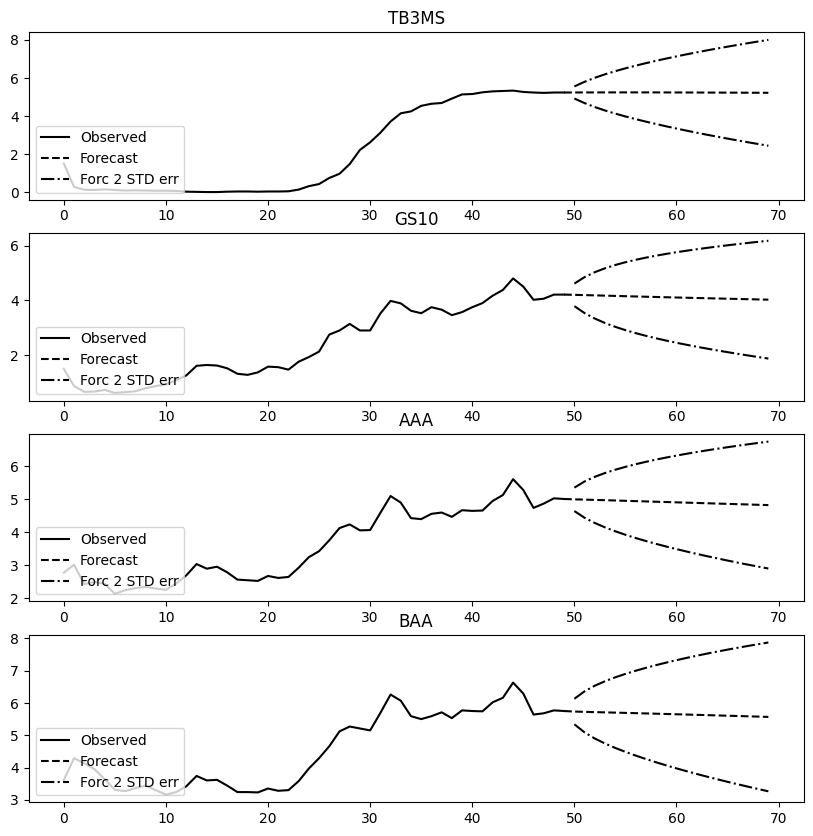

In [24]:
fig = res.plot_forecast(steps=20, alpha=0.05, plot_conf_int=True, n_last_obs=50)

# изменим положение легенды для каждого подграфика
# for i in range(y.shape[1]):
# 	fig.axes[i].legend(loc=3)

plt.show()

## IRF

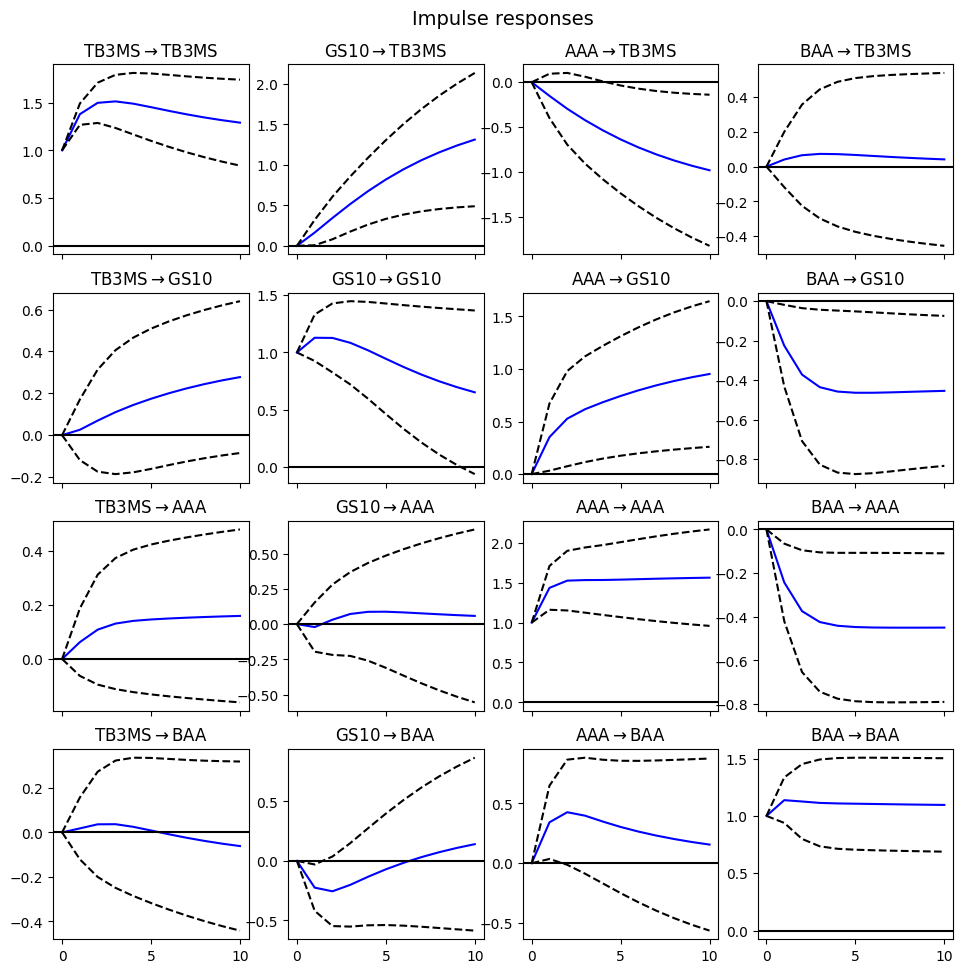

In [25]:
res.irf(periods=10).plot(signif=0.05)
plt.show()

## Причинность

In [27]:
res.test_granger_causality(caused=['AAA', 'BAA'], causing=['TB3MS', 'GS10'], signif=0.01).summary()

Test statistic,Critical value,p-value,df
5.150,2.525,0.000,"(8, 1340)"


In [28]:
res.test_granger_causality(caused= ['TB3MS', 'GS10'], causing=['AAA', 'BAA'], signif=0.01).summary()

Test statistic,Critical value,p-value,df
2.504,2.525,0.011,"(8, 1340)"
